In [2]:
from astropy.table import Table
import numpy as np
lens_samples = Table.read('lens_samples.fits')
mask_stack = lens_samples['if_obs_stack'].data
mask_single = lens_samples['if_obs_single'].data
stack_samples = lens_samples[mask_stack]
single_samples = lens_samples[mask_single]
stack_samples.sort('SNR_stack')
single_samples.sort('SNR_stack')
print(np.count_nonzero(mask_stack), np.count_nonzero(mask_single))

161548 76396


In [3]:
stack_samples[0:5]

<Table length=5>
    thetaE_s0           mass_s0         z_s0         re_s0         ... if_obs_stack if_obs_single noise_seed
     float64            float64       float64       float64        ...     bool          bool       int64   
------------------ ------------------ ------- -------------------- ... ------------ ------------- ----------
0.2515839339238274 42588092643.569145   1.954  0.12071596852606585 ...         True         False       1459
  0.65809837615499 112132690882.41939  2.4352  0.21492642425191413 ...         True         False        781
0.9632576424948887  321010828515.9149  1.0121  0.07803567144969906 ...         True         False        479
 0.879538616612968 265604253882.34683  2.4917 0.033467176941648503 ...         True         False       2455
0.5115178267215648  68725598624.12091  2.6067 0.015921294768468045 ...         True         False       1490

## Generate the example lensing image, fig.2

In [4]:
from SimCsstLens.SimLensImage.MockSurvey import MockSurvey
from SimCsstLens.SimLensImage import Util as SSU

class NewMockSurvey(MockSurvey):
    def load_ideal_lens_from_table(self, this_table):
        self.src_z = this_table['z_s0'].data.reshape(1, -1)
        self.src_xs = this_table['x_s0'].data.reshape(1, -1)
        self.src_ys = this_table['y_s0'].data.reshape(1, -1)
        self.src_Re = this_table['re_s0'].data.reshape(1, -1)
        self.src_q = this_table['q_s0'].data.reshape(1, -1)
        self.src_pa = this_table['pa_s0'].data.reshape(1, -1)
        self.src_thetaE = this_table['thetaE_s0'].data.reshape(1, -1)
        
        self.dfl_Re = this_table['re_l'].data
        self.dfl_z = this_table['z_l'].data
        self.dfl_q = this_table['q_l'].data
        self.dfl_vdisp = this_table['vdisp_l'].data
        for band in self.bands[0:-1]:
            self.__dict__[f'src_app_mag_{band}'] = this_table[f'mag_{band}_s0'].data.reshape(1, -1)
            self.__dict__[f'dfl_app_mag_{band}'] =  this_table[f'mag_{band}_l'].data
        self.n_ideal_lenses = len(self.dfl_z)
        
from SimCsstLens.SimLensImage.MockSurvey import MockSurvey
survey = NewMockSurvey(config_path="./", config_file='csst_setting.yaml')
survey.load_ideal_lens_from_table(stack_samples)

lens_id = 3
this_sim_obj_0 = survey.sim_obj_from(lens_id)
survey.lensing_image_from(this_sim_obj_0)
this_sn, this_mu = survey.sn_and_mu_from(this_sim_obj_0)
src_id=0
print(this_sn)

[[14.65807095 11.11570835  8.54715141  4.99107129 20.00051207]]


In [5]:
begin_id = np.argmin(np.abs(stack_samples['SNR_stack'].data - 100))
lens_id = begin_id+3
this_sim_obj_1 = survey.sim_obj_from(lens_id)
survey.lensing_image_from(this_sim_obj_1)
this_sn, this_mu = survey.sn_and_mu_from(this_sim_obj_1)
src_id=0
print(this_sn)

[[ 68.55748068  51.81139584  44.70797756  34.17531505 100.03931783]]


In [6]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import make_lupton_rgb
from matplotlib.colors import LogNorm
import scienceplots
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import numpy as np

plt.style.use(['science','no-latex', 'nature'])
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# Set the background color and grid style
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.alpha'] = 0.5

columnwidth = 3.33
aspect_ratio = 1

snr_list = [20, 100]
for iii, this_sim_obj in enumerate([this_sim_obj_0, this_sim_obj_1]):
    fig = plt.figure(constrained_layout=False, figsize=(columnwidth*4+0.6, columnwidth*aspect_ratio))
    gs = fig.add_gridspec(2, 8, wspace=0.0, hspace=0.1)

    ctr = int(this_sim_obj[src_id]['g'].image_map_cps.shape[0]/2.0)
    hw = int(np.ceil(3.0/0.074))
    limits = [ctr-hw, ctr+hw+1]
    
    this_ax = fig.add_subplot(gs[0, 0])
    im = this_ax.imshow(this_sim_obj[src_id]['g'].image_map_cps, cmap='Greys', origin='lower')
    this_ax.text(0.05, 0.85, "g", transform = this_ax.transAxes)
    this_ax.set_aspect('equal')
    fontprops = fm.FontProperties(size=8)
    bar = AnchoredSizeBar(
        this_ax.transData, 
        1.0/0.074,   #the width of scale bar indicate the corresponding coordinate scale
        '1 arcsec',  #lable of scale bar
        'lower left',  #location of scale bar
        frameon=False,  #don't show the scale bar pannel
        color='black',   #set the color of scale-bar  character 
        size_vertical=0.05,  #verticle size of scale bar
        pad=1.,  #Padding around the label and size bar, in fraction of the font size. Defaults to 0.1
        fontproperties=fontprops  #Font properties for the label text.
    )
    this_ax.add_artist(bar)
    this_ax.set_xlim(*limits)
    this_ax.set_ylim(*limits)
    this_ax.set_xticklabels([])
    this_ax.set_yticklabels([])
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    
    
    
    this_ax = fig.add_subplot(gs[0, 1])
    im = this_ax.imshow(this_sim_obj[src_id]['r'].image_map_cps, cmap='Greys', origin='lower')
    this_ax.text(0.05, 0.85, "r", transform = this_ax.transAxes)
    this_ax.set_aspect('equal')
    this_ax.set_xlim(*limits)
    this_ax.set_ylim(*limits)
    this_ax.set_xticklabels([])
    this_ax.set_yticklabels([])
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    
    this_ax = fig.add_subplot(gs[1, 0])
    im = this_ax.imshow(this_sim_obj[src_id]['i'].image_map_cps, cmap='Greys', origin='lower')
    this_ax.text(0.05, 0.85, "i", transform = this_ax.transAxes)
    this_ax.set_aspect('equal')
    this_ax.set_xlim(*limits)
    this_ax.set_ylim(*limits)
    this_ax.set_xticklabels([])
    this_ax.set_yticklabels([])
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    
    this_ax = fig.add_subplot(gs[1, 1])
    im = this_ax.imshow(this_sim_obj[src_id]['z'].image_map_cps, cmap='Greys', origin='lower')
    this_ax.text(0.05, 0.85, "z", transform = this_ax.transAxes)
    this_ax.set_aspect('equal')
    this_ax.set_xlim(*limits)
    this_ax.set_ylim(*limits)
    this_ax.set_xticklabels([])
    this_ax.set_yticklabels([])
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    
    this_ax = fig.add_subplot(gs[:, 2:4])
    im = this_ax.imshow(this_sim_obj[src_id]['stack']['image_map_cps'], cmap='Greys', origin='lower')
    this_ax.text(0.05, 0.9, "stack", transform = this_ax.transAxes)
    this_ax.set_aspect('equal')
    fontprops = fm.FontProperties(size=10)
    bar = AnchoredSizeBar(
        this_ax.transData, 
        1.0/0.074,   #the width of scale bar indicate the corresponding coordinate scale
        '1 arcsec',  #lable of scale bar
        'lower left',  #location of scale bar
        frameon=False,  #don't show the scale bar pannel
        color='black',   #set the color of scale-bar  character 
        size_vertical=0.05,  #verticle size of scale bar
        pad=1.,  #Padding around the label and size bar, in fraction of the font size. Defaults to 0.1
        fontproperties=fontprops  #Font properties for the label text.
    )
    this_ax.add_artist(bar)
    this_ax.set_xlim(*limits)
    this_ax.set_ylim(*limits)
    this_ax.set_xticklabels([])
    this_ax.set_yticklabels([])
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    
    
    color_image = make_lupton_rgb(
        this_sim_obj[src_id]['i'].image_map_cps, 
        this_sim_obj[src_id]['r'].image_map_cps,
        this_sim_obj[src_id]['g'].image_map_cps, 
        Q=1, 
        stretch=0.9,
    )
    this_ax = fig.add_subplot(gs[:, 4:6])
    im = this_ax.imshow(color_image, origin='lower')
    this_ax.text(0.05, 0.9, "gri", transform = this_ax.transAxes, color='white')
    this_ax.set_aspect('equal')
    this_ax.set_xlim(*limits)
    this_ax.set_ylim(*limits)
    this_ax.set_xticklabels([])
    this_ax.set_yticklabels([])
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    
    this_ax = fig.add_subplot(gs[:, 6:])
    im = this_ax.imshow(
        (this_sim_obj[src_id]['stack']['image_map_cps'] - this_sim_obj[src_id]['stack']['lens_image_cps'])/this_sim_obj[src_id]['stack']['noise_map_cps'],
        origin='lower', 
        cmap='Greys', 
        vmin=0.0,
    )
    divider = make_axes_locatable(this_ax)
    cax = divider.append_axes("right", size="5%", pad=0.05) 
    plt.colorbar(im, cax=cax)
    this_ax.text(0.05, 0.9, r"Arc-SNR: $\sim$"+f"{snr_list[iii]:.0f}", transform = this_ax.transAxes)
    this_ax.set_aspect('equal')
    this_ax.set_xlim(*limits)
    this_ax.set_ylim(*limits)
    this_ax.set_xticklabels([])
    this_ax.set_yticklabels([])
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    
    fig.savefig(f'figures/color_image_{snr_list[iii]}.pdf', bbox_inches='tight')
    plt.close(fig)

## check small thetaE, image

In [22]:
stack_samples.sort('thetaE_s0')
begin_id = np.argmin(np.abs(stack_samples['thetaE_s0'].data - 0.08))
lens_id = begin_id+8
survey.load_ideal_lens_from_table(stack_samples)
this_sim_obj = survey.sim_obj_from(lens_id)
survey.lensing_image_from(this_sim_obj)
print('thetaE is', stack_samples['thetaE_s0'].data[lens_id])
this_sn, this_mu = survey.sn_and_mu_from(this_sim_obj_0)
print(this_sn)

thetaE is 0.08079936950139863
[[14.65807095 11.11570835  8.54715141  4.99107129 20.00051207]]


In [23]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import make_lupton_rgb
from matplotlib.colors import LogNorm
import scienceplots
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import numpy as np

plt.style.use(['science','no-latex', 'nature'])
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# Set the background color and grid style
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.alpha'] = 0.5

columnwidth = 3.33
aspect_ratio = 1

fig = plt.figure(constrained_layout=False, figsize=(columnwidth*4+0.6, columnwidth*aspect_ratio))
gs = fig.add_gridspec(2, 8, wspace=0.0, hspace=0.1)

ctr = int(this_sim_obj[src_id]['g'].image_map_cps.shape[0]/2.0)
hw = int(np.ceil(0.5/0.074))
limits = [ctr-hw, ctr+hw+1]

this_ax = fig.add_subplot(gs[0, 0])
im = this_ax.imshow(this_sim_obj[src_id]['g'].image_map_cps, cmap='Greys', origin='lower')
this_ax.text(0.05, 0.85, "g", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
fontprops = fm.FontProperties(size=8)
bar = AnchoredSizeBar(
    this_ax.transData, 
    0.2/0.074,   #the width of scale bar indicate the corresponding coordinate scale
    '0.2 arcsec',  #lable of scale bar
    'lower left',  #location of scale bar
    frameon=False,  #don't show the scale bar pannel
    color='black',   #set the color of scale-bar  character 
    size_vertical=0.05,  #verticle size of scale bar
    pad=1.,  #Padding around the label and size bar, in fraction of the font size. Defaults to 0.1
    fontproperties=fontprops  #Font properties for the label text.
)
this_ax.add_artist(bar)
this_ax.set_xlim(*limits)
this_ax.set_ylim(*limits)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

this_ax = fig.add_subplot(gs[0, 1])
im = this_ax.imshow(this_sim_obj[src_id]['r'].image_map_cps, cmap='Greys', origin='lower')
this_ax.text(0.05, 0.85, "r", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
this_ax.set_xlim(*limits)
this_ax.set_ylim(*limits)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

this_ax = fig.add_subplot(gs[1, 0])
im = this_ax.imshow(this_sim_obj[src_id]['i'].image_map_cps, cmap='Greys', origin='lower')
this_ax.text(0.05, 0.85, "i", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
this_ax.set_xlim(*limits)
this_ax.set_ylim(*limits)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

this_ax = fig.add_subplot(gs[1, 1])
im = this_ax.imshow(this_sim_obj[src_id]['z'].image_map_cps, cmap='Greys', origin='lower')
this_ax.text(0.05, 0.85, "z", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
this_ax.set_xlim(*limits)
this_ax.set_ylim(*limits)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

this_ax = fig.add_subplot(gs[:, 2:4])
im = this_ax.imshow(this_sim_obj[src_id]['stack']['image_map_cps'], cmap='Greys', origin='lower')
this_ax.text(0.05, 0.9, "stack", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
fontprops = fm.FontProperties(size=10)
bar = AnchoredSizeBar(
    this_ax.transData, 
    0.2/0.074,   #the width of scale bar indicate the corresponding coordinate scale
    '0.2 arcsec',  #lable of scale bar
    'lower left',  #location of scale bar
    frameon=False,  #don't show the scale bar pannel
    color='black',   #set the color of scale-bar  character 
    size_vertical=0.05,  #verticle size of scale bar
    pad=1.,  #Padding around the label and size bar, in fraction of the font size. Defaults to 0.1
    fontproperties=fontprops  #Font properties for the label text.
)
this_ax.add_artist(bar)
this_ax.set_xlim(*limits)
this_ax.set_ylim(*limits)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])


color_image = make_lupton_rgb(
    this_sim_obj[src_id]['i'].image_map_cps, 
    this_sim_obj[src_id]['r'].image_map_cps,
    this_sim_obj[src_id]['g'].image_map_cps, 
    Q=1, 
    stretch=0.9,
)
this_ax = fig.add_subplot(gs[:, 4:6])
im = this_ax.imshow(color_image, origin='lower')
this_ax.text(0.05, 0.9, "gri", transform = this_ax.transAxes, color='white')
this_ax.set_aspect('equal')
this_ax.set_xlim(*limits)
this_ax.set_ylim(*limits)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

this_ax = fig.add_subplot(gs[:, 6:])
im = this_ax.imshow(
    (this_sim_obj[src_id]['stack']['image_map_cps'] - this_sim_obj[src_id]['stack']['lens_image_cps'])/this_sim_obj[src_id]['stack']['noise_map_cps'],
    origin='lower', 
    cmap='Greys',
    vmin=0.0,
)
divider = make_axes_locatable(this_ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
cbar = plt.colorbar(im, cax=cax)
formatter = ticker.FormatStrFormatter('%.0f')
cbar.formatter = formatter
# Update the ticks and labels
cbar.update_ticks()
this_ax.text(0.05, 0.9, r"Arc-SNR: $\sim$"+f"{this_sn[0][-1]:.0f}", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
this_ax.set_xlim(*limits)
this_ax.set_ylim(*limits)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

fig.savefig(f'figures/color_image_small_thetaE.pdf', bbox_inches='tight')
plt.close(fig)

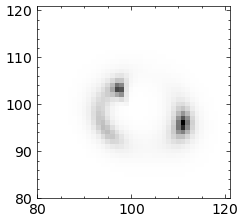

In [24]:
this_sim_obj[0]['g'].generate_ideal_image(200, 0.01, 4, if_eval_deflections=True)
plt.figure()
plt.imshow(this_sim_obj[0]['g'].ideal_source_image_cps, origin='lower', cmap='Greys')
plt.xlim(100-20, 100+20+1)
plt.ylim(100-20, 100+20+1)
plt.show()

In [13]:
this_sim_obj[0]['g'].ideal_source_image_cps.shape

(200, 200)

In [15]:
136/2

68.0

## Generate image for lens modeling

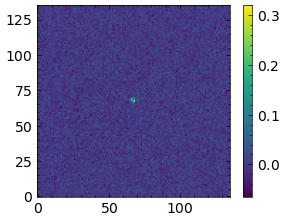

0.0009294855392416085
0.017147703177797697
1200.0


In [36]:
exp_time = this_sim_obj[0]['stack']['eff_exp_time']
image_cps = this_sim_obj[src_id]['stack']['image_map_cps']
plt.figure()
plt.imshow(image_cps, origin='lower')
plt.colorbar()
plt.show()
margin = image_cps[0:10,:]
print(np.median(margin))
print(np.std(margin))
print(exp_time)

In [48]:
import matplotlib.gridspec as gridspec
def retrive_lenses_from(lens_sample_table, SNR=20):
    survey = NewMockSurvey(config_path="./", config_file='csst_setting.yaml')
    survey.load_ideal_lens_from_table(lens_sample_table)

    imgWD = 2
    nimgs = 30
    ncols = 5
    nrows = int(nimgs/ncols)
    fig = plt.figure(figsize = (imgWD*ncols,imgWD*nrows))
    gds = gridspec.GridSpec(nrows, ncols)
    gds.update(wspace=0.0, hspace=0.0) 
    
    start_id = np.abs(lens_sample_table['SNR_stack'].data - SNR).argmin()
    start_id = start_id -int(nimgs/2)
    arc_image_list = [None]*nimgs
    noise_map_list = [None]*nimgs
    arc_snr_list = [None]*nimgs
    for j in range(nimgs):
        this_sim_obj = survey.sim_obj_from(j+start_id)
        survey.lensing_image_from(this_sim_obj)
        arc_image_list[j] = this_sim_obj[src_id]['stack']['image_map_cps'] - this_sim_obj[src_id]['stack']['lens_image_cps']
        snr_map = arc_image_list[j]/this_sim_obj[src_id]['stack']['noise_map_cps']
        arc_snr, _ = survey.sn_and_mu_from(this_sim_obj)
        arc_snr = arc_snr[0,-1]
        arc_snr_list[j] = arc_snr
        noise_map_list[j] = this_sim_obj[src_id]['stack']['noise_map_cps']
        
        axs = plt.subplot(gds[int(j/(ncols)), j%(ncols)])
        axs.imshow(snr_map, origin='lower', cmap='jet')
        axs.text(0.05, 0.9, f"Arc-SNR: {arc_snr:.2f}", transform = axs.transAxes)
        axs.text(0.05, 0.8, f"Max-SNR: {snr_map.max():.2f}", transform = axs.transAxes)
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        axs.set_xticks([])
        axs.set_yticks([])
        axs.set_aspect('equal')
    plt.show()
    plt.close(fig)
    print('-'*20)

    return arc_image_list, noise_map_list, arc_snr_list, lens_sample_table[start_id:start_id+nimgs]

def log_var_bin(start=None, end=None, nbin=None):
    log_start = np.log10(start)
    log_end = np.log10(end)
    log_space = log_end - log_start
    log_step = log_space / nbin

    log_bin_left = log_start + np.arange(nbin)*log_step
    log_bin_mid = log_start + np.arange(nbin)*log_step + log_step*0.5
    log_bin_right = log_start + np.arange(nbin)*log_step + log_step

    return 10**log_bin_left, 10**log_bin_mid, 10**log_bin_right

log_var_bin(start=1, end=1000, nbin=3)

(array([  1.,  10., 100.]),
 array([  3.16227766,  31.6227766 , 316.22776602]),
 array([  10.,  100., 1000.]))

In [49]:
log_var_bin(start=20, end=1000, nbin=5)

(array([ 20.        ,  43.73448296,  95.63524998, 209.12791052,
        457.30505193]),
 array([ 29.57515273,  64.67270066, 141.42135624, 309.24949471,
        676.24333781]),
 array([  43.73448296,   95.63524998,  209.12791052,  457.30505193,
        1000.        ]))

In [50]:
survey.psf_fwhm_dict

{'g': 0.051, 'r': 0.064, 'i': 0.076, 'z': 0.089, 'stack': 0.07}

In [51]:
psf_fwhm_stack = survey.psf_fwhm_dict['g'] + survey.psf_fwhm_dict['r'] + survey.psf_fwhm_dict['i'] + survey.psf_fwhm_dict['z']
psf_fwhm_stack /= 4
psf_kernel_stack = SSU.gauss_psf(
    npix=None, 
    dpix=survey.dpix, 
    fwhm=psf_fwhm_stack, 
    nsub=4
)

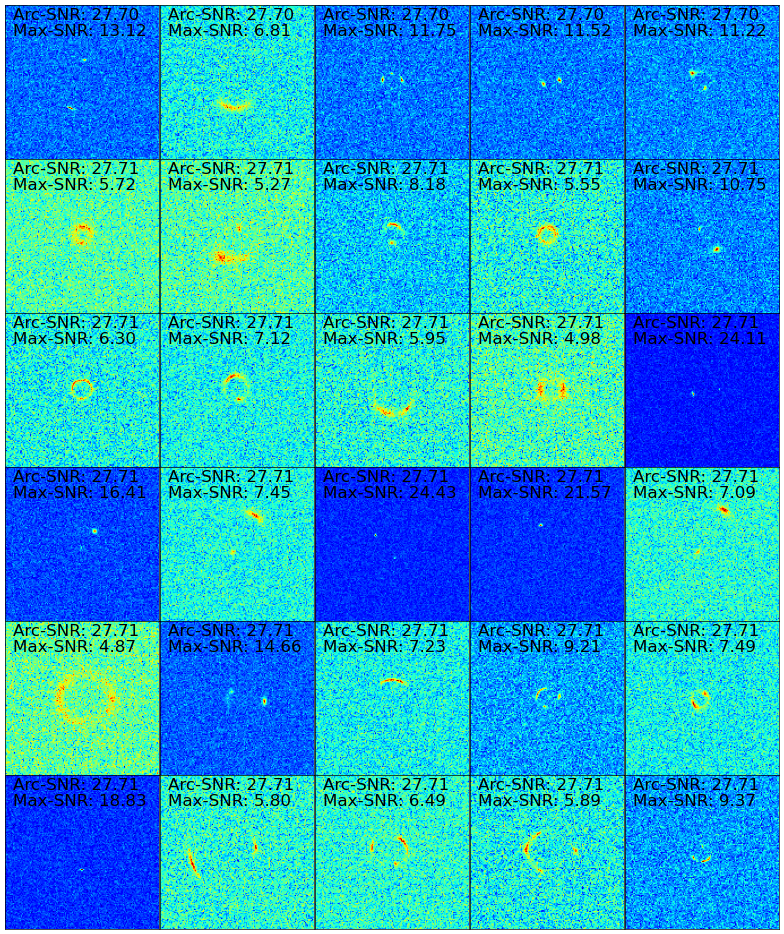

--------------------


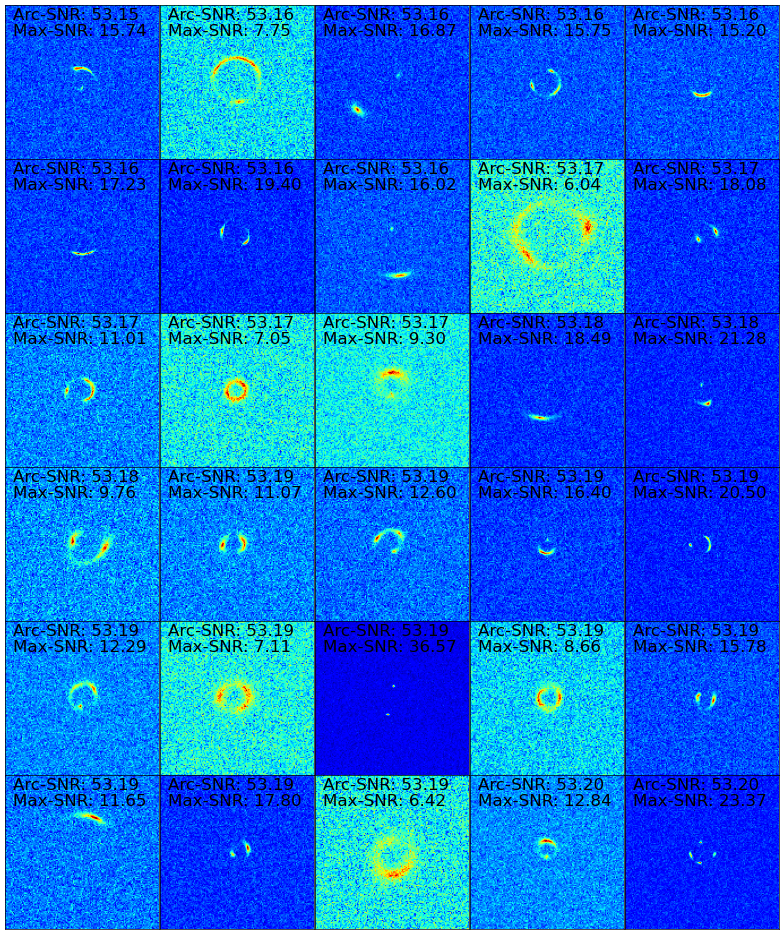

--------------------


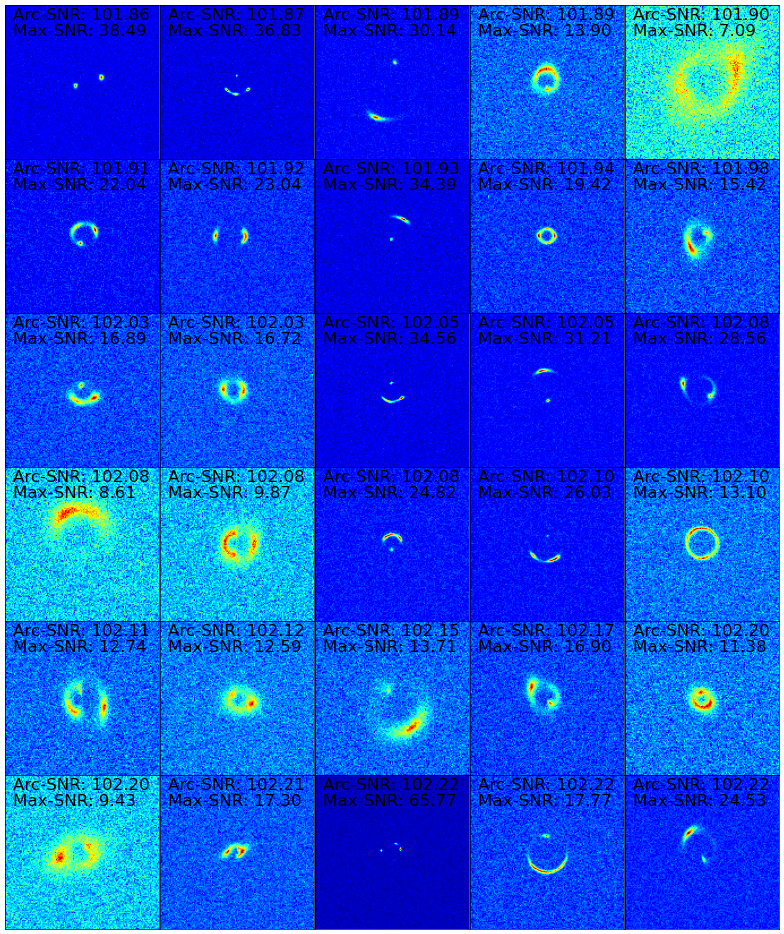

--------------------


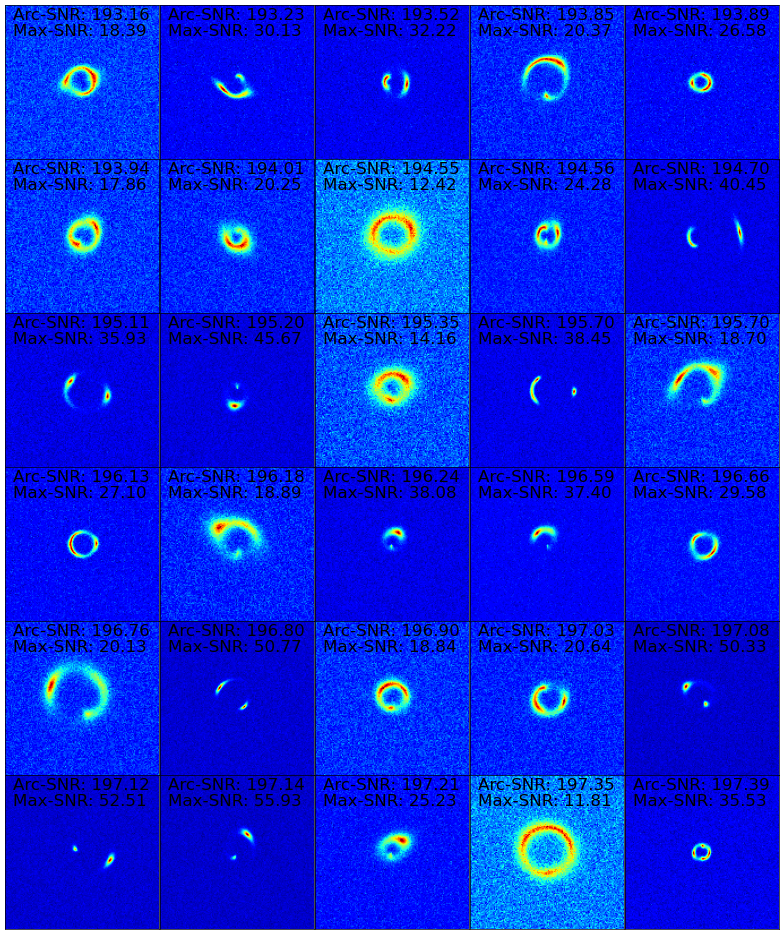

--------------------


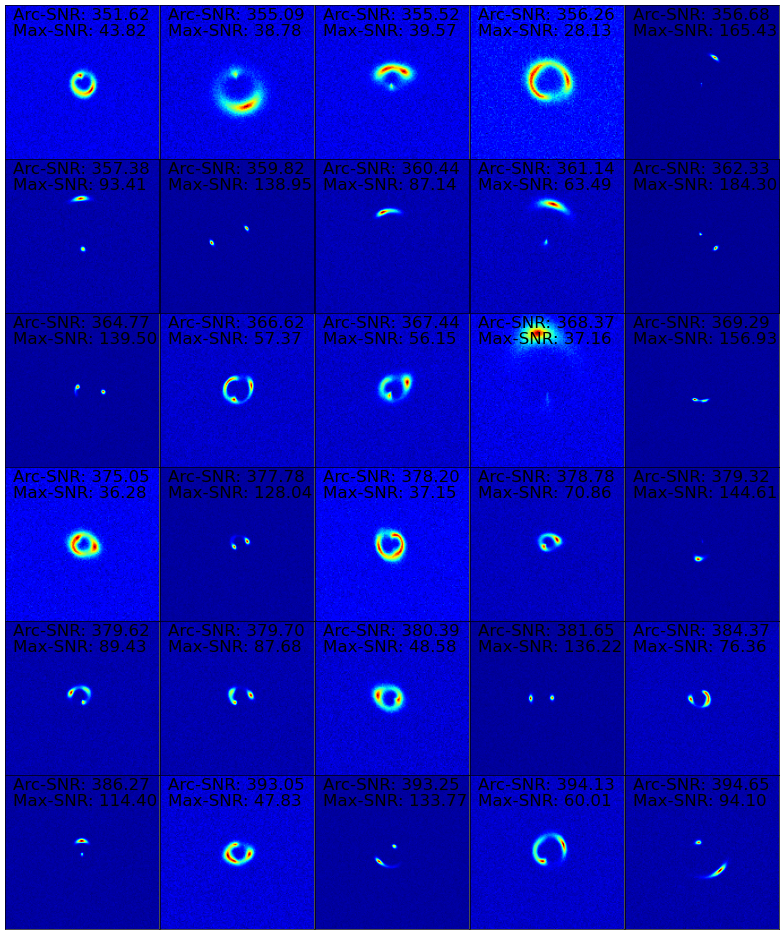

--------------------


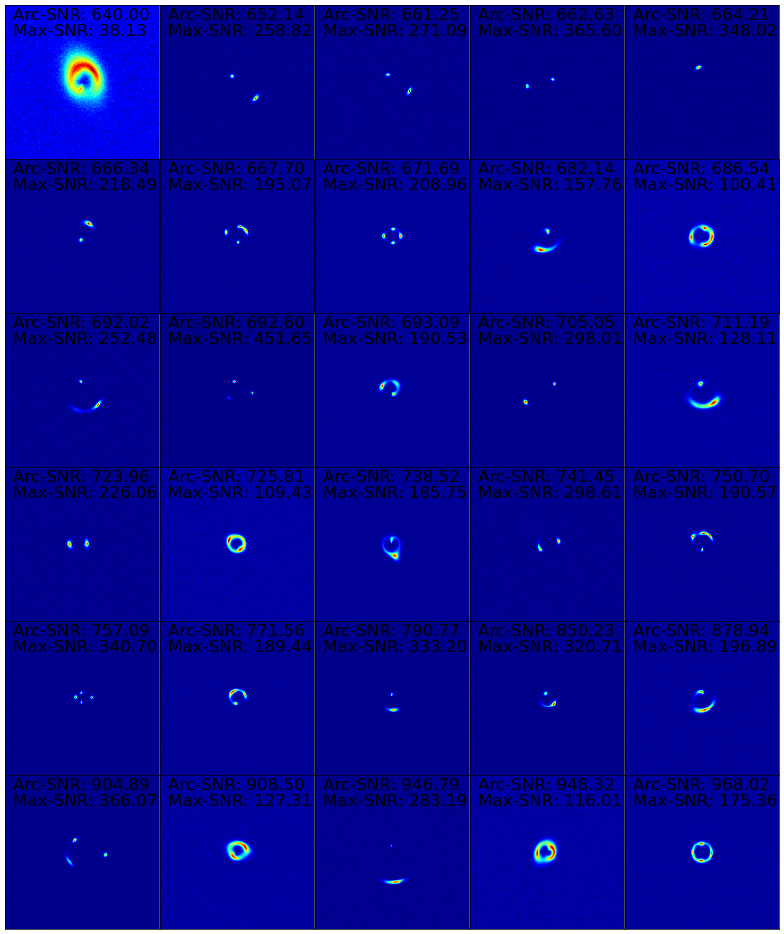

--------------------


In [65]:
import pickle
import gzip

stack_samples.sort('SNR_stack')

# snr_bins = [21, 50, 100, 250, 500, 950]
snr_bins_l, snr_bins_m, snr_bins_r = log_var_bin(start=20, end=1000, nbin=6)
for this_snr in snr_bins_m:
    # this_snr = 950
    mask = stack_samples['thetaE_s0'].data > 0.45
    lens_model_samples = stack_samples[mask]
    info_list = list(retrive_lenses_from(lens_model_samples, SNR=this_snr))
    # info_list.append(survey.psf_kernel_dict['z'])
    info_list.append(psf_kernel_stack)
    
    filename = f'modeling_data/csst_image_{this_snr:.0f}.pklz'
    with gzip.open(filename, 'wb') as file:
        pickle.dump(info_list, file)

In [42]:
survey.psf_fwhm_dict

{'g': 0.051, 'r': 0.064, 'i': 0.076, 'z': 0.089, 'stack': 0.07}

In [27]:
survey.psf_kernel_dict['z'].shape

(5, 5)

In [62]:
with np.printoptions(precision=0):
    print(snr_bins_m)

[ 28.  53. 102. 196. 376. 722.]
